In [1]:
# To ignore warnings

import os, warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the COVID-19 dataset mentioned in section 5.2

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Country/Region'] == 'US']
df.fillna(0, inplace=True)
# df = df[df['New_Cases'] >= 0]

In [4]:
# Feature engineering

df['New_Cases'] = df['Confirmed'].diff().fillna(0)

In [24]:
# Trim the dataset into specific training set

start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-03-21')
df_train = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [51]:
df = df_train

In [52]:
df

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,New_Cases
208935,2020-03-01,US,0,32,7.0,1,7.0
208936,2020-03-02,US,0,55,7.0,6,23.0
208937,2020-03-03,US,0,74,7.0,7,19.0
208938,2020-03-04,US,0,107,7.0,11,33.0
208939,2020-03-05,US,0,184,7.0,12,77.0
208940,2020-03-06,US,0,237,7.0,14,53.0
208941,2020-03-07,US,0,403,7.0,17,166.0
208942,2020-03-08,US,0,519,7.0,21,116.0
208943,2020-03-09,US,0,594,7.0,22,75.0
208944,2020-03-10,US,0,782,8.0,28,188.0


In [54]:
# Define the size of the training and testing set

train_size = int(len(df) * 0.8)
train_data = df['New_Cases'][:train_size]
test_data = df['New_Cases'][train_size:]

In [55]:
# Detrending the time series using differencing

train_data_diff = train_data.diff().dropna()
test_data_diff = test_data.diff().dropna()

In [101]:
# Scale the data to the range [0, 1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(np.array(train_data_diff).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data_diff).reshape(-1, 1))

In [102]:
# Function to create sequences of data for LSTM input

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [251]:
time_step = 2  # Number of time steps to look back

In [252]:
# Create training sequences

X_train, y_train = create_sequences(scaled_train, time_step)
X_test, y_test = create_sequences(np.concatenate((scaled_train[-time_step:], scaled_test)), time_step)

In [253]:
# Reshape the data for LSTM input

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [254]:
# Build and compile the LSTM model

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [255]:
# Train the model

model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1824 - val_loss: 1.0694
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1692 - val_loss: 1.0241
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1569 - val_loss: 0.9803
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1452 - val_loss: 0.9374
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1340 - val_loss: 0.8950
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1232 - val_loss: 0.8527
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1127 - val_loss: 0.8104
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1027 - val_loss: 0.7681
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0931 - val_loss: 0.7259
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0840 - val_loss: 0.6840
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0756 - val_loss: 0.6427
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0679 - val_loss: 0.6024


In [256]:
# Make predictions on the training and test data

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


In [257]:
# Inverse transform the predictions to the original scale

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [270]:
# Fetch the actual future new cases for comparison

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df_test = pd.read_csv(url)

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test[df_test['Country/Region'] == 'US']
df_test.fillna(0, inplace=True)

df_test['New_Cases'] = df_test['Confirmed'].diff().fillna(0)

start_date = pd.Timestamp('2020-03-22')
end_date = pd.Timestamp('2020-03-24')
df_test = df_test[(df_test['Date'] >= start_date) & (df_test['Date'] <= end_date)]

actual_future_cases = df_test['New_Cases'].values


In [259]:
df_test

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,New_Cases
208956,2020-03-22,US,0,34944,178.0,603,8919.0
208957,2020-03-23,US,0,46096,178.0,790,11152.0
208958,2020-03-24,US,0,56714,348.0,1033,10618.0


In [260]:
next = 3  # Number of days to forecast

In [261]:
# Prepare the input for future predictions

future_inputs = df['New_Cases'][-time_step:].values.reshape(1, time_step, 1)
future_predictions = []

for _ in range(next):
    future_pred = model.predict(future_inputs)
    future_predictions.append(future_pred[0, 0])
    future_inputs = np.append(future_inputs[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [262]:
future_predictions

array([[2135.039  ],
       [2218.0652 ],
       [ 481.74344]], dtype=float32)

In [263]:
# Invert the differencing for future predictions

last_value = df['New_Cases'].iloc[-1]
future_predictions_orig = last_value + np.cumsum(future_predictions)

In [264]:
# df

In [265]:
last_value

5995.0

In [266]:
future_predictions_orig

array([ 8130.039 , 10348.1045, 10829.848 ], dtype=float32)

In [269]:
# Evaluate the predictions using RMSE and MAPE metric

rmse = np.sqrt(mean_squared_error(actual_future_cases, future_predictions_orig))
mape = mean_absolute_percentage_error(actual_future_cases, future_predictions_orig)

print(f'Root Mean Squared Error for LSTM with detrending: {rmse}')
print(f'Mean Absolute Percentage Error for LSTM with detrending: {mape}')

Root Mean Squared Error for RNN: 661.7116133786718
Mean Absolute Percentage Error for RNN: 0.060165173934066424


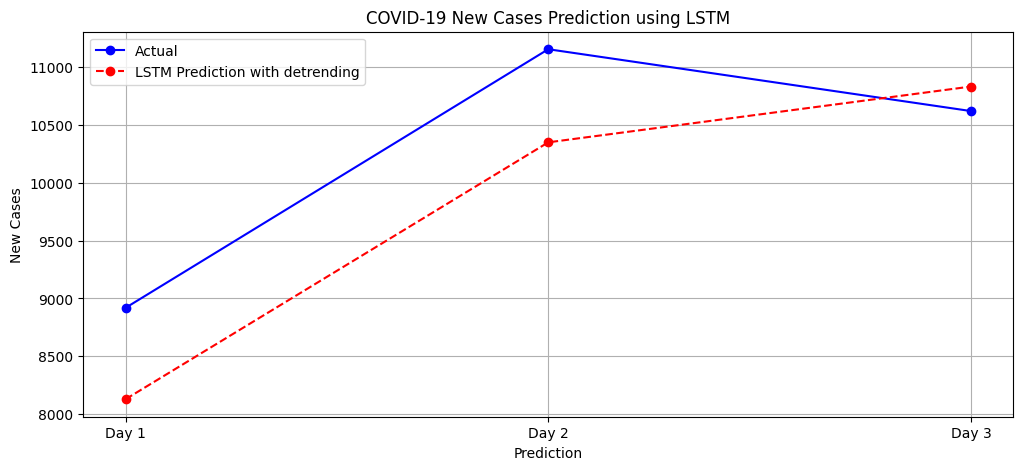

In [268]:
# Visualize the predictions as shown in Figure 7

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = actual_future_cases
predicted_new_cases = future_predictions_orig

plt.figure(figsize=(12, 5))
plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='LSTM Prediction with detrending')

plt.title('COVID-19 New Cases Prediction using LSTM')
plt.xlabel('Prediction')
plt.ylabel('New Cases')
plt.legend()

plt.grid(True)
plt.show()
